In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

In [2]:
from IPython.display import Latex

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [5]:
DIM = 2
COLORS = ['red', 'blue']

# 2-D mean of ones
M1 = np.ones((DIM,))
# 2-D mean of threes
M2 = 3 * np.ones((DIM,))
# 2-D covariance of 0.3
C1 = np.diag(0.3 * np.ones((DIM,)))
# 2-D covariance of 0.2
C2 = np.diag(0.2 * np.ones((DIM,)))

In [6]:
def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

In [7]:
m = 10
# generate NUM points from gaussian 1
x1 = generate_gaussian(M1, C1, m)
# labels
y1 = np.ones((x1.shape[0],))
# generate NUM points from gaussian 2
x2 = generate_gaussian(M2, C2, m)
y2 = -np.ones((x2.shape[0],))
# join
x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)
print('x {} y {}'.format(x.shape, y.shape))
# write
# with open('gaussiandata.pickle', 'wb') as f:
#     pickle.dump((x, y), f)

x (20, 2) y (20,)


In [8]:
def plot_data_with_labels(ax, x, y, w=None, b=None):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    if w is None:
        return
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.arange(0, 6)
    ax.plot(x, x * slope + intercept, 'k-')

<function matplotlib.pyplot.show(*args, **kw)>

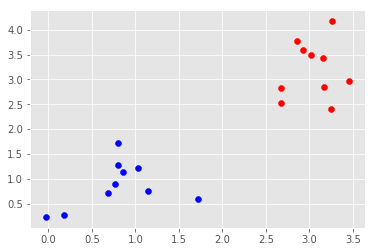

In [9]:
fix, ax = plt.subplots()
plot_data_with_labels(ax, x, y);
plt.show

Recall that the dual optimization problem with hard margin is expressed as:
$$    
\begin{equation*}
        \max_\alpha \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i,j=1}^m \alpha_i \alpha_j y_i y_j K(x_i, x_j)
\end{equation*}
$$
$$
\begin{equation*}
\text{subject to: }  0 \le \alpha_i \wedge \sum_{i=1}^m \alpha_i y_i =0
\end{equation*}
$$
Converting to a minimization problem we have:
$$
\begin{equation*}
        \min_\alpha  \frac{1}{2} \sum_{i,j=1}^m \alpha_i \alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^m \alpha_i
\end{equation*}
$$
$$
\begin{equation*}
    \text{subject to: }  0 \le \alpha_i \wedge \alpha \; y^\top =0
\end{equation*}
$$
Using CVX API:
$$
\begin{equation*}
    \min  \frac{1}{2} \; x^\top \; P \; x + q^\top \; x
\end{equation*}
$$
$$
\begin{equation*}
    \text{s.t. } G x \le h
\end{equation*}
$$

In [10]:
def fit_hard_margin(x, y): 
    m = x.shape[0]
    # we'll solve the dual
    K = y[:, None] * x
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((m, 1)))
    G = matrix(-np.eye(m))
    h = matrix(np.zeros(m))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

In [11]:
# fit svm classifier
alphas = fit_hard_margin(x, y)
# get weights
w = np.sum(alphas * y[:, None] * x, axis = 0)
# get bias
cond = (alphas > 1e-4).reshape(-1)
b = y[cond] - np.dot(x[cond], w)
bias = b[0]

In [12]:
#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [0.32219984 0.1968532  0.51905306]
w =  [-0.78852148 -0.64524487]
b =  2.7387045710931237


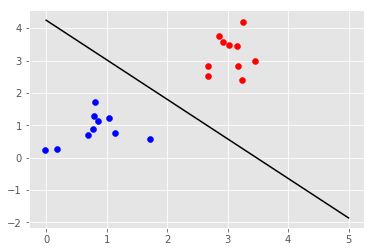

In [13]:
fix, ax = plt.subplots()
plot_data_with_labels(ax, x, y, w, bias)
plt.show()

In [14]:
# 2-D mean of ones
M1 = np.ones((DIM,))
# 2-D mean of threes
M2 = 3 * np.ones((DIM,))
# 2-D covariance of 0.3
C1 = np.diag(1 * np.ones((DIM,)))
# 2-D covariance of 0.2
C2 = np.diag(1 * np.ones((DIM,)))
# generate NUM points from gaussian 1
x1 = generate_gaussian(M1, C1, m)
# labels
y1 = np.ones((x1.shape[0],))
# generate NUM points from gaussian 2
x2 = generate_gaussian(M2, C2, m)
y2 = -np.ones((x2.shape[0],))
# join
x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)
print('x {} y {}'.format(x.shape, y.shape))

x (20, 2) y (20,)


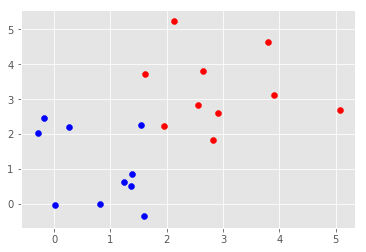

In [15]:
fix, ax = plt.subplots()
plot_data_with_labels(ax, x, y)
plt.show()

The problem is no longer linearly separable. We will use a soft margin:
$$
\begin{equation*}
        \min_\alpha  \frac{1}{2} \sum_{i,j=1}^m \alpha_i \alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^m \alpha_i
\end{equation*}
$$
$$
\begin{equation*}
    \text{subject to: }  0 \le \alpha_i \le C \wedge \alpha \; y^\top =0
\end{equation*}
$$

In [16]:
def fit_with_soft_margin(x, y, C): 
    m = x.shape[0]

    
    K = y[:, None] * x
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((m, 1)))
    G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = matrix(np.zeros(m))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

In [17]:
# fit svm classifier
C = 0.1
alphas = fit_with_soft_margin(x, y, C)
# get weights
w = np.sum(alphas * y[:, None] * x, axis = 0)
# get bias
cond = (alphas > 1e-4).reshape(-1)
b = y[cond] - np.dot(x[cond], w)
bias = b[0]

In [18]:
#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [0.09999999 0.05996242 0.09999999 0.1        0.09999998 0.05996261
 0.09999999 0.1        0.1        0.1       ]
w =  [-0.62569418 -0.48675904]
b =  2.2823225031071273


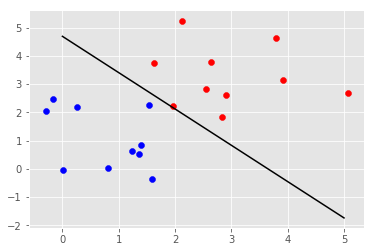

In [19]:
fix, ax = plt.subplots()
plot_data_with_labels(ax, x, y, w, bias)
plt.show()